<a href="https://colab.research.google.com/github/Ugo5738/Face-Recognition-with-Facenet/blob/main/Face_Recognition_with_FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install mtcnn
!pip install Pillow

     |████████████████████████████████| 2.3 MB 7.6 MB/s 


In [6]:
from numpy import asarray, savez_compressed
from numpy import expand_dims, load
from random import choice

from os import listdir
from os.path import isdir

from PIL import Image
import matplotlib.pyplot as plt

from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC

import mtcnn
print(mtcnn.__version__)
from mtcnn.mtcnn import MTCNN

0.1.0


In [7]:
# extract a single face from an image
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    # convert to RGB when needed
    image = image.convert('RGB')
    pixels = asarray(image)

    # MTCNN detector with default weights
    detector = MTCNN()
    results = detector.detect_faces(pixels)

    # extract bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix incase it returns a negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    # extract face
    face = pixels[y1:y2, x1:x2]

    # resize pixels to model standard size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

image 1 (160, 160, 3)
image 2 (160, 160, 3)
image 3 (160, 160, 3)
image 4 (160, 160, 3)
image 5 (160, 160, 3)
image 6 (160, 160, 3)
image 7 (160, 160, 3)
image 8 (160, 160, 3)
image 9 (160, 160, 3)
image 10 (160, 160, 3)
image 11 (160, 160, 3)
image 12 (160, 160, 3)
image 13 (160, 160, 3)
image 14 (160, 160, 3)
image 15 (160, 160, 3)
image 16 (160, 160, 3)
image 17 (160, 160, 3)


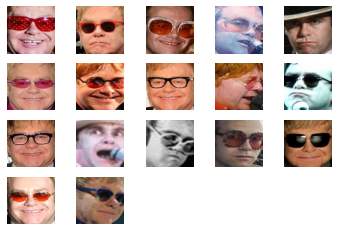

In [8]:
folder = '/content/5-celebrities/train/elton_john/'
i = 1

for filename in listdir(folder):
    path = folder + filename
    face = extract_face(path)
    print(f'image {i}', face.shape)

    plt.subplot(4, 5, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

In [9]:
# load images and extract faces for all images
def load_faces(directory):
    faces = list()

    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

In [10]:
def load_dataset(directory):
    X, y = list(), list()

    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the directory
        if not isdir(path):
            continue
        # load faces in subdirectory
        faces = load_faces(path)

        # create labels
        labels = [subdir for _ in range(len(faces))]
        print('>loaded %d examples for class: %s' % (len(faces), subdir))

        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [11]:
train_X, train_y = load_dataset('/content/5-celebrities/train/')
print(train_X.shape, train_y.shape)

test_X, test_y = load_dataset('/content/5-celebrities/val/')
print(test_X.shape, test_y.shape)

savez_compressed('5-celebrities.npz', train_X, train_y, test_X, test_y)

>loaded 22 examples for class: mindy_kaling
>loaded 17 examples for class: elton_john
>loaded 14 examples for class: ben_afflek
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
(25, 160, 160, 3) (25,)


In [12]:
# get face embedding for one face 
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction
    yhat = model.predict(samples)
    return yhat[0] # get embedding

In [15]:
# load face dataset
data = load('5-celebrities.npz')
train_X, train_y, test_X, test_y = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [17]:
model = load_model('/content/drive/MyDrive/facenet_keras.h5')
print('Loaded Model')
# print(model.inputs)
# print(model.outputs)

Loaded Model


In [18]:
# convert each face to an embedding
train_X_emb = list()

for face_pixels in train_X:
    embedding = get_embedding(model, face_pixels)
    train_X_emb.append(embedding)
train_X_emb = asarray(train_X_emb)
print(train_X_emb.shape)

test_X_emb = list()
for face_pixels in test_X:
    embedding = get_embedding(model, face_pixels)
    test_X_emb.append(embedding)
test_X_emb = asarray(test_X_emb)
print(test_X_emb.shape)

savez_compressed('5-celebrities-embeddings.npz', train_X_emb, train_y, test_X_emb, test_y)

(93, 128)
(25, 128)


In [19]:
# load dataset
emb_data = load('5-celebrities-embeddings.npz')
emb_train_X, emb_train_y, emb_test_X, emb_test_y = emb_data['arr_0'], emb_data['arr_1'], emb_data['arr_2'], emb_data['arr_3']
print('Dataset: train = %d samples, test = %d samples' % (emb_train_X.shape[0], emb_test_X.shape[0]))

Dataset: train = 93 samples, test = 25 samples


In [20]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
en_train_X = in_encoder.transform(emb_train_X)
en_test_X = in_encoder.transform(emb_test_X)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(emb_train_y)
en_train_y = out_encoder.transform(emb_train_y)
en_test_y = out_encoder.transform(emb_test_y)

In [21]:
# fit SVC model
model = SVC(kernel='linear')
model.fit(en_train_X, en_train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
# predict
yhat_train = model.predict(en_train_X)
yhat_test = model.predict(en_test_X)

# score
score_train = accuracy_score(en_train_y, yhat_train)
score_test = accuracy_score(en_test_y, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


Predicted: mindy_kaling (92.337)
Expected: mindy_kaling


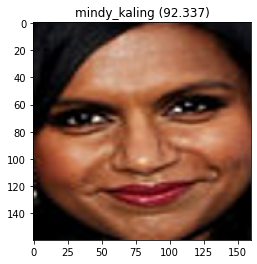

In [76]:
def test_model(en_train_X, en_train_y, en_test_X, en_test_y, emb_data):
    # refit model with probability set to True
    model = SVC(kernel='linear', probability=True)
    model.fit(en_train_X, en_train_y)

    # test model on random example from the test dataset
    test_X_faces = data['arr_2']
    selection = choice([i for i in range(en_test_X.shape[0])])
    random_face_pixels = test_X_faces[selection]
    random_face_emb = en_test_X[selection]
    random_face_class = en_test_y[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])

    # face prediction
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)
    
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0, class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)

    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    print('Expected: %s' % random_face_name[0])

    # plot for fun
    plt.imshow(random_face_pixels)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    plt.title(title)
    plt.show()

test_model(en_train_X, en_train_y, en_test_X, en_test_y, emb_data)